## Source:

Code in this notebook borrowed from: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/code Thank you to Yassine Ghouzam for providing it!

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

#### Loading data + basic inspection:

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

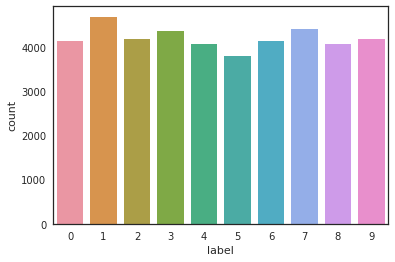

In [4]:
y_train = train['label']
X_train = train.drop(labels=['label'], axis=1)

g = sns.countplot(y_train) # similar counts for each digit in the set

### Checks for null / missing values:

In [9]:
X_train.isnull().any().unique()

array([False])

In [8]:
test.isnull().any().unique()

array([False])

In [12]:
X_train[0:10]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X_train.shape

(42000, 784)

### Normalization:

* First run a grayscale normalization to adjust for differences in illumination among images
* The Neural Net will also converge more quickly during training when values are on a [0,1] range as opposed to [0, 255]

In [11]:
X_train = X_train / 255.0
test = test / 255.0

### Reshape data for Keras:

The train and test images are in the form of 1D vectors with 784 values each.  Keras expects the data in 3D format, where the third dimension represents color channels in the data.  These data are in grayscale, so we only add one value in the third dimension.  RGB data would include three values in the third dimension.  

In [14]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [15]:
X_train.shape

(42000, 28, 28, 1)

### Encode Labels:
* Make the categories one-hot vectors.  Again done for Keras' expectations ex 2 -> [0,0,1,0,0,0,0,0,0,0]

In [18]:
y_train = to_categorical(y_train, num_classes = len(y_train.unique()))

In [20]:
y_train[0:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Split the training and validation sets:

In [21]:
# set the seed:
random_seed = 2